# Fitting a spectrum model using Gradient Descent Based Optimization.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import jax.numpy as jnp

Use FP64 just in case.

In [5]:
from jax.config import config

config.update("jax_enable_x64", True)

Here, we use a mock CH4 spectrum precomputed by ExoJAX. Also, we normalize it and add some noise.

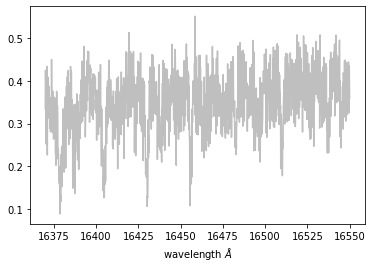

In [10]:
import pkg_resources
from exojax.spec.unitconvert import nu2wav
from exojax.test.data import SAMPLE_SPECTRA_CH4_NEW

# loading the data
filename = pkg_resources.resource_filename(
    'exojax', 'data/testdata/' + SAMPLE_SPECTRA_CH4_NEW)
dat = pd.read_csv(filename, delimiter=",", names=("wavenumber", "flux"))
nusd = dat['wavenumber'].values
flux = dat['flux'].values
wavd = nu2wav(nusd)

sigmain = 0.05
norm = 20000
nflux = flux / norm + np.random.normal(0, sigmain, len(wavd))


plt.plot(wavd[::-1],nflux,alpha=0.5,color="gray")
plt.xlabel("wavelength $\AA$")
plt.show()

Let's make a model, which should be include CH4, CIA (H2-H2), spin rotation, and response... So, import everthing we need. We use PreMODIT as "opa".

In [12]:
from exojax.utils.grids import wavenumber_grid
from exojax.spec.atmrt import ArtEmisPure
from exojax.spec.api import MdbExomol
from exojax.spec.opacalc import OpaPremodit
from exojax.spec.contdb import CdbCIA
from exojax.spec.opacont import OpaCIA
from exojax.spec.response import ipgauss_sampling
from exojax.spec.spin_rotation import convolve_rigid_rotation
from exojax.utils.instfunc import resolution_to_gaussian_std

Again recall this figure.

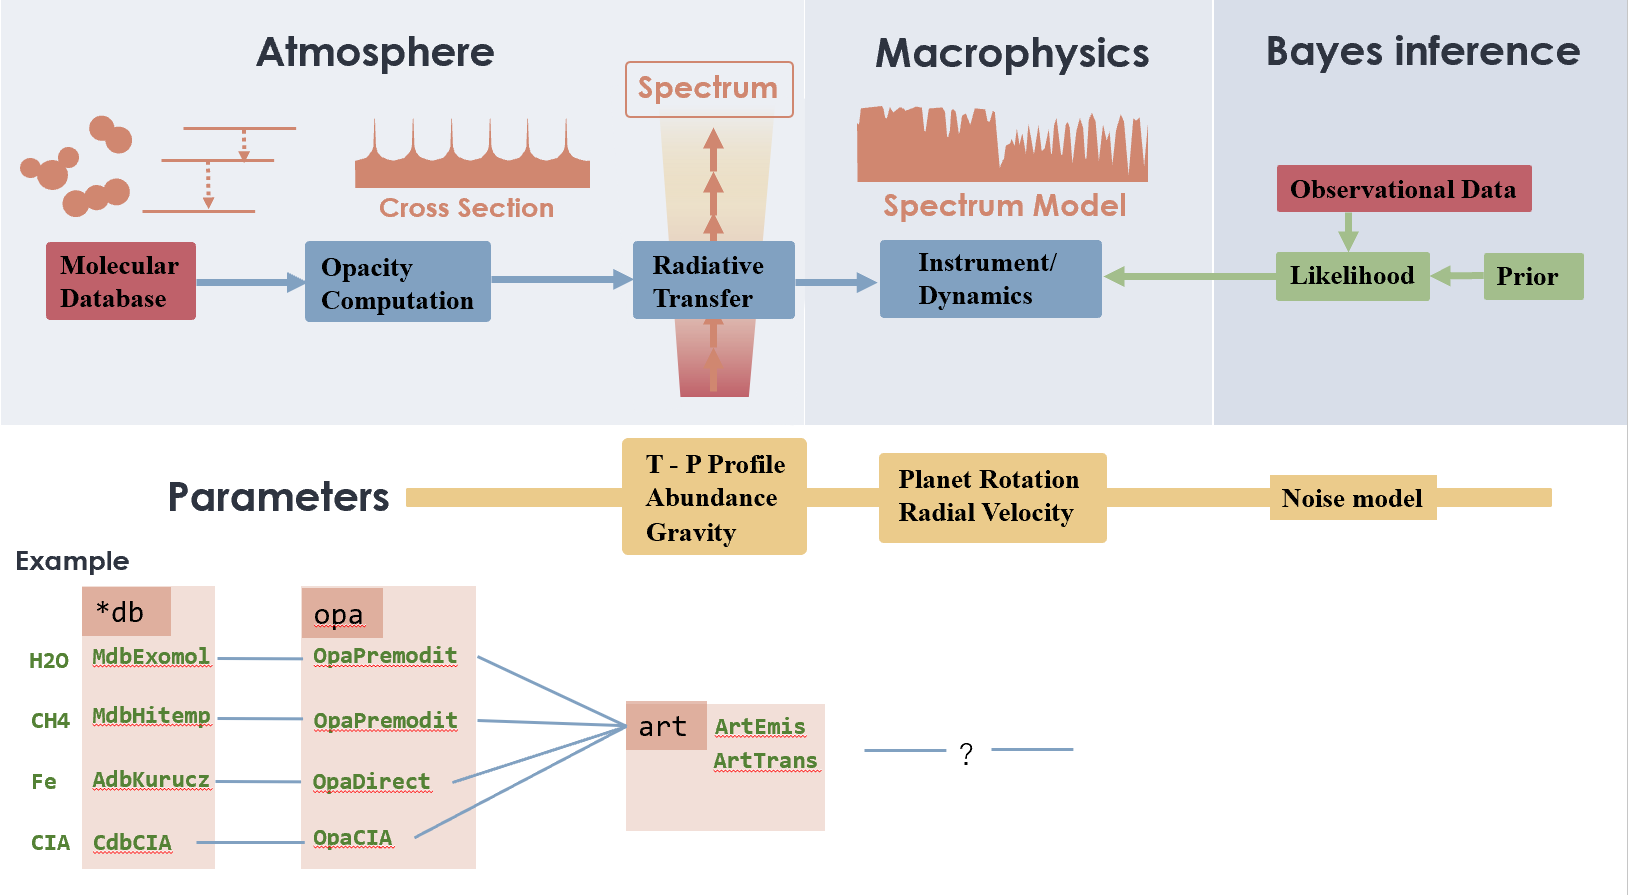

In [13]:
from IPython.display import Image
Image("../exojax.png")

Here we will infer here Rp, RV, MMR_CO, T0, alpha, and Vsini. 

First, set the model wavenumber grids, which should cover the observational range, and the instrumental setting, and Atmospheric RT (layer) setting, "art".

In [18]:
Nx = 1500
nu_grid, wav, res = wavenumber_grid(np.min(wavd) - 5.0,
                                np.max(wavd) + 5.0,
                                Nx,
                                unit="AA",
                                xsmode="premodit")

#Atmospheric setting by "art"
Tlow = 400.0
Thigh = 1500.0
art = ArtEmisPure(nu_grid, pressure_top=1.e-8, pressure_btm=1.e2, nlayer=100)
art.change_temperature_range(Tlow, Thigh)
Mp = 33.2

#instrumental setting
Rinst = 100000.
beta_inst = resolution_to_gaussian_std(Rinst)

xsmode =  premodit
xsmode assumes ESLOG in wavenumber space: mode=premodit


/home/kawahara/exojax/src/exojax/utils/grids.py:126: UserWarning: Resolution may be too small. R=129859.29489937567
  warnings.warn('Resolution may be too small. R=' + str(resolution),


Loading the databases, "mdb" for ExoMol/CH4 and "cdb" for CIA. Also, define "opa" for both db. It takes ~ a few minites to initialize OpaPremodit (if you do not have the database, it takes more for downloading for the first time). Have a coffee and wait.

In [19]:
### CH4 setting (PREMODIT)
mdb = MdbExomol('.database/CH4/12C-1H4/YT10to10/',
                nurange=nu_grid,
                gpu_transfer=False)
print('N=', len(mdb.nu_lines))
diffmode = 0
opa = OpaPremodit(mdb=mdb,
                  nu_grid=nu_grid,
                  diffmode=diffmode,
                  auto_trange=[Tlow, Thigh],
                  dit_grid_resolution=0.2)

## CIA setting
from exojax.spec import molinfo

cdbH2H2 = CdbCIA('.database/H2-H2_2011.cia', nu_grid)
opcia = OpaCIA(cdb=cdbH2H2, nu_grid=nu_grid)
mmw = 2.33  # mean molecular weight
mmrH2 = 0.74
molmassH2 = molinfo.molmass_isotope('H2')
vmrH2 = (mmrH2 * mmw / molmassH2)  # VMR

HITRAN exact name= (12C)(1H)4
HITRAN exact name= (12C)(1H)4
Background atmosphere:  H2


/home/kawahara/exojax/src/exojax/utils/molname.py:49: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.",UserWarning)
/home/kawahara/exojax/src/exojax/utils/molname.py:49: UserWarning: No isotope number identified.
  warnings.warn("No isotope number identified.",UserWarning)
/home/kawahara/exojax/src/exojax/spec/molinfo.py:28: UserWarning: exact molecule name is not Exomol nor HITRAN form.
  warnings.warn("exact molecule name is not Exomol nor HITRAN form.")
/home/kawahara/exojax/src/exojax/spec/molinfo.py:29: UserWarning: No molmass available
  warnings.warn("No molmass available", UserWarning)


Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06000-06100.trans.bz2
Reading .database/CH4/12C-1H4/YT10to10/12C-1H4__YT10to10__06100-06200.trans.bz2
.broad is used.
Broadening code level= a1
default broadening parameters are used for  23  J lower states in  40  states
N= 76483758
OpaPremodit: params automatically set.
Robust range: 397.77407283130566 - 1689.7679243628259 K
Tref changed: 296.0K->1153.6267095763965K


uniqidx: 100%|██████████| 2/2 [00:04<00:00,  2.39s/it]


Premodit: Twt= 461.3329793405918 K Tref= 1153.6267095763965 K
H2-H2


We have only 76,483,758 CH4 lines. 

In [21]:
print(len(mdb.nu_lines))

76483758


Setting a velocity grid for spin and response...

In [54]:
from exojax.utils.astrofunc import gravity_jupiter
from exojax.utils.grids import velocity_grid
vsini_max = 100.0
vr_array = velocity_grid(res, vsini_max)


Now we write the model, which is used in HMC-NUTS.

In [55]:

#response and rotation settings 


def model_c(params,boost):
    Rp,RV,MMR_CH4,T0,alpha,vsini,RV=params*boost
    
    Tarr = art.powerlaw_temperature(T0, alpha)
    g = gravity_jupiter(Rp=Rp, Mp=Mp)  # gravity in the unit of Jupiter
    #molecule
    xsmatrix = opa.xsmatrix(Tarr, art.pressure)
    mmr_arr = art.constant_mmr_profile(MMR_CH4)
    dtaumCH4 = art.opacity_profile_lines(xsmatrix, mmr_arr, opa.mdb.molmass, g)
    #continuum
    logacia_matrix = opcia.logacia_matrix(Tarr)
    dtaucH2H2 = art.opacity_profile_cia(logacia_matrix, Tarr, vmrH2, vmrH2,
                                        mmw, g)
    #total tau
    dtau = dtaumCH4 + dtaucH2H2
    F0 = art.run(dtau, Tarr) / norm
    Frot = convolve_rigid_rotation(F0, vr_array, vsini, u1=0.0, u2=0.0)
    mu = ipgauss_sampling(nusd, nu_grid, Frot, beta_inst, RV, vr_array)
    return mu

    

Here, we use JAXopt as an optimizer. JAXopt is not automatically installed. If you need install it by pip:

pip install jaxopt

In [56]:
import jaxopt

We use a GradientDescent as an optimizer. Let's normalize the parameters. 

In [57]:
#Rp,RV,MMR_CH4,T0,alpha,vsini, RV
boost=np.array([1.0,10.0,0.1,1000.0,1.e-3,10.0,10.0])
initpar=np.array([0.8,9.0,0.01,1200.0,0.1,17.0,0.0])/boost

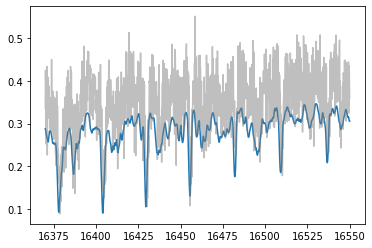

In [58]:
f = model_c(initpar,boost)
plt.plot(wavd[::-1],f)
plt.plot(wavd[::-1],nflux,alpha=0.5,color="gray")


Define the objective function by a L2 norm.

In [59]:
def objective(params):
    f=nflux-model_c(params,boost)
    g=jnp.dot(f,f)
    return g

Then, run the gradient descent. 

In [60]:
gd = jaxopt.GradientDescent(fun=objective, maxiter=1000, stepsize=1.e-4)
res = gd.run(init_params=initpar)
params, state = res

The best-fit parameters

In [61]:
params*boost

DeviceArray([3.16212731e+00, 9.00000000e+00, 6.83902209e-02,
             1.96979169e+03, 1.00019192e-01, 1.99522829e+01,
             9.94556417e+00], dtype=float64)

Plot the results. It works well!

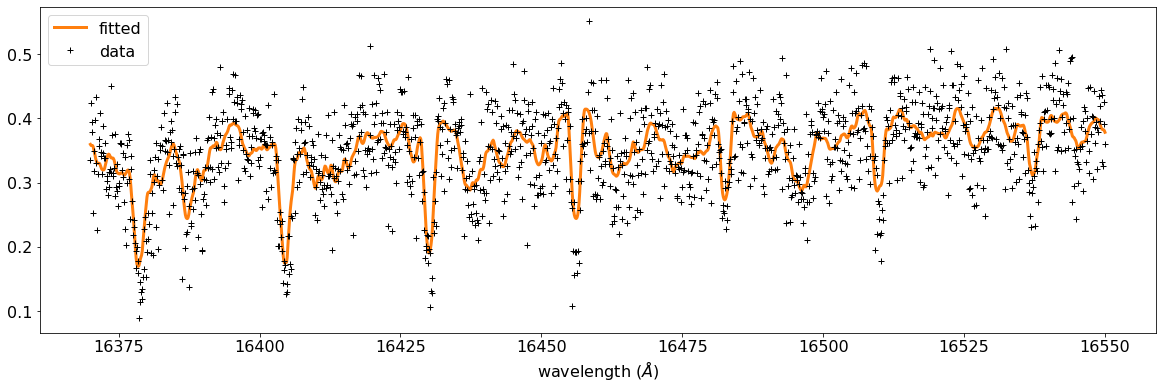

In [66]:
model=model_c(params,boost)
inmodel=model_c(initpar,boost)
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
ax.plot(wavd[::-1],model,color="C1",lw=3,label="fitted")
#ax.plot(wavd[::-1],inmodel,color="gray",lw=3,label="initial parameter")
ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
plt.xlabel("wavelength ($\AA$)",fontsize=16)
plt.legend(fontsize=16)
plt.tick_params(labelsize=16)
plt.savefig("gradient_descent_jaxopt.png")

We can do the optimization one by one update. It's useful when you wanna visualize the optimization process.

In [67]:
import tqdm
gd = jaxopt.GradientDescent(fun=objective, stepsize=1.e-4)
state = gd.init_state(initpar)
params=np.copy(initpar)

params_gd=[]
Nit=300
for _ in  tqdm.tqdm(range(Nit)):
    params,state=gd.update(params,state)
    params_gd.append(params)

100%|██████████| 300/300 [01:15<00:00,  3.99it/s]


## Using ADAM optimizer

You might use ADAM, instead of a simple GD. Yes, you can.

In [68]:
from jaxopt import OptaxSolver
import optax

In [69]:
import tqdm
adam = OptaxSolver(opt=optax.adam(2.e-2), fun=objective)
state = adam.init_state(initpar)
params=np.copy(initpar)

params_adam=[]
Nit=300
for _ in  tqdm.tqdm(range(Nit)):
    params,state=adam.update(params,state)
    params_adam.append(params)

100%|██████████| 300/300 [00:39<00:00,  7.65it/s]


In [120]:
# if you wanna optimize at once, run the following: 
# res = solver.run(init_params=initpar)
# params, state = res

## make a movie

Make the movie directory (mkdir movie), and let's make squential png files.

In [76]:
inmodel=model_c(initpar,boost)
for i in tqdm.tqdm(range(Nit)):
    spec_gd=model_c(params_gd[i],boost)
    spec_adam=model_c(params_adam[i],boost)
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20,6.0))
    ax.plot(wavd[::-1],spec_gd,color="C0",lw=3,label="GD")
    ax.plot(wavd[::-1],spec_adam,color="C1",lw=3,label="ADAM")
    ax.plot(wavd[::-1],inmodel,color="gray",label="initial parameter")
    ax.plot(wavd[::-1],nflux,"+",color="black",label="data")
    plt.xlabel("wavelength ($\AA$)",fontsize=16)
    plt.tick_params(labelsize=16)
    plt.ylim(0.0,0.6)
    plt.legend(loc="lower left",fontsize=14)
    plt.savefig("movie/gradient_descent_jaxopt"+str(i).zfill(4)+".png")
    plt.close()

100%|██████████| 300/300 [01:24<00:00,  3.56it/s]


In [ ]:
#for instance, make a movie by
# > ffmpeg -r 30 -i gradient_descent_jaxopt%04d.png -vcodec libx264 -pix_fmt yuv420p -r 60 outx.mp4